# Spaceship Titanic

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

**train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.**
* `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
* `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* `Destination` - The planet the passenger will be debarking to.
* `Age`- The age of the passenger.
* `VIP` - Whether the passenger has paid for special VIP service during the voyage.
* `RoomService, FoodCourt, ShoppingMall, Spa, VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* `Name` - The first and last names of the passenger.
* `Transported` - Whether the passenger was transported to another dimension. This is the `target`, the column you are trying to predict.
**test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.Your task is to predict the value of Transported for the passengers in this set.**
**sample_submission.csv - A submission file in the correct format.**
* `PassengerId` - Id for each passenger in the test set.
* `Transported` - The target. For each passenger, predict either True or False.

Metrics: `accuracy`


# Data overview

In [48]:
# Import all the tools
import warnings
from tqdm import tqdm_notebook
import seaborn as sns
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
# from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

train = pd.read_csv("C:/Users\misha\Desktop/sample_project_1/spaceship/train.csv")
test = pd.read_csv("C:/Users\misha\Desktop/sample_project_1/spaceship/test.csv")
sub = pd.read_csv('C:/Users\misha\Desktop/sample_project_1/spaceship/sample_submission.csv')

# plots inside the notebook
%matplotlib inline
print('Train Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    train.shape, train.isna().sum().sum(), train.duplicated().sum()))
print('Test Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    test.shape, test.isna().sum().sum(), test.duplicated().sum()))
train_d = train.drop_duplicates()

if train.shape == train_d.shape:
    print('No duplicates')
else:
    print('Dropping Duplicates\nNew Train Shape: {}'.format(train_d.shape))

Train Shape: (8693, 14)
Missing Data: 2324
Duplicates: 0

Test Shape: (4277, 13)
Missing Data: 1117
Duplicates: 0

No duplicates


In [5]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [6]:
test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


This is a classificataion task with two classes: 1 or 0. Let's encode the target value

In [4]:
train['Transported'] = train['Transported'].astype(int)
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0


# EDA & FE

In [5]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported       int32
dtype: object

In [6]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

## Target

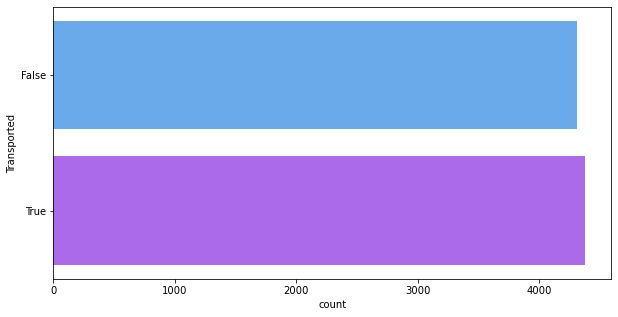

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(y=train['Transported'], palette='cool', orient='h')
plt.show()

## Create features

In [49]:
y = train['Transported']
train.drop('Transported',axis=1, inplace=True)
y = y.astype(int)

train['Ageismissing'] = train['Age'].isnull()
train['Ageismissing'] = train['Ageismissing'].astype(int)
train['Age'].fillna(train['Age'].mean(), inplace=True)
test['Ageismissing'] = test['Age'].isnull()
test['Ageismissing'] = test['Ageismissing'].astype(int)
test['Age'].fillna(test['Age'].mean(), inplace=True)

train['RoomService'].fillna(0, inplace=True)
test['RoomService'].fillna(0, inplace=True)
train['PaidRoomService'] = train['RoomService'] > 0
train['PaidRoomService'] = train['PaidRoomService'].astype(int)
test['PaidRoomService'] = test['RoomService'] > 0
test['PaidRoomService'] = test['PaidRoomService'].astype(int)

train['FoodCourt'].fillna(0, inplace=True)
test['FoodCourt'].fillna(0, inplace=True)
train['PaidFoodCourt'] = train['FoodCourt'] > 0
train['PaidFoodCourt'] = train['PaidFoodCourt'].astype(int)
test['PaidFoodCourt'] = test['FoodCourt'] > 0
test['PaidFoodCourt'] = test['PaidFoodCourt'].astype(int)

train['ShoppingMall'].fillna(0, inplace=True)
test['ShoppingMall'].fillna(0, inplace=True)
train['PaidShoppingMall'] = train['ShoppingMall'] > 0
train['PaidShoppingMall'] = train['PaidShoppingMall'].astype(int)
test['PaidShoppingMall'] = test['ShoppingMall'] > 0
test['PaidShoppingMall'] = test['PaidShoppingMall'].astype(int)

train['Spa'].fillna(0, inplace=True)
test['Spa'].fillna(0, inplace=True)
train['PaidSpa'] = train['Spa'] > 0
train['PaidSpa'] = train['PaidSpa'].astype(int)
test['PaidSpa'] = test['Spa'] > 0
test['PaidSpa'] = test['PaidSpa'].astype(int)

train['VRDeck'].fillna(0, inplace=True)
test['VRDeck'].fillna(0, inplace=True)
train['PaidVRDeck'] = train['VRDeck'] > 0
train['PaidVRDeck'] = train['PaidVRDeck'].astype(int)
test['PaidVRDeck'] = test['VRDeck'] > 0
test['PaidVRDeck'] = test['PaidVRDeck'].astype(int)



train['TotalSpend'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']
train['PctRoomService'] = train['RoomService']/train['TotalSpend']
train['PctFoodCourt'] = train['FoodCourt']/train['TotalSpend']
train['PctShoppingMall'] = train['ShoppingMall']/train['TotalSpend']
train['PctSpa'] = train['Spa']/train['TotalSpend']
train['PctVRDeck'] = train['VRDeck']/train['TotalSpend']
fill_cols = ['PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']
train[fill_cols] = train[fill_cols].fillna(0)

test['TotalSpend'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']
test['PctRoomService'] = test['RoomService']/test['TotalSpend']
test['PctFoodCourt'] = test['FoodCourt']/test['TotalSpend']
test['PctShoppingMall'] = test['ShoppingMall']/test['TotalSpend']
test['PctSpa'] = test['Spa']/test['TotalSpend']
test['PctVRDeck'] = test['VRDeck']/test['TotalSpend']
fill_cols = ['PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']
test[fill_cols] = test[fill_cols].fillna(0)

# cabin
train.loc[train['Cabin'].isnull(), 'Cabin'] = 'None/None/None'
test.loc[test['Cabin'].isnull(), 'Cabin'] = 'None/None/None'
# train['Deck'] = train['Cabin'].apply(lambda x: str(x).split('/')[0])
# train['Side'] = train['Cabin'].apply(lambda x: str(x).split('/')[2])
# test['Deck'] = test['Cabin'].apply(lambda x: str(x).split('/')[0])
# test['Side'] = test['Cabin'].apply(lambda x: str(x).split('/')[2])
train[['deck', 'num','side']] = train['Cabin'].str.split('/', expand=True)
test[['deck', 'num','side']] = test['Cabin'].str.split('/', expand=True)


train['deck']=train['deck'].replace({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7, 'None':8})
test['deck']=test['deck'].replace({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7, 'None':8})
train['side']=train['side'].replace({'S':0, 'P':1,'None':2})
test['side']=test['side'].replace({'S':0, 'P':1,'None':2})
# train_deck = pd.get_dummies(train[["Deck"]])
# test_deck = pd.get_dummies(test[["Deck"]])
# train = pd.concat([train, train_deck], axis=1)
# test = pd.concat([test, test_deck], axis=1)
# train.drop('Deck', axis=1, inplace=True)
# test.drop('Deck', axis=1, inplace=True)

# train_Side = pd.get_dummies(train[["Side"]])
# test_Side = pd.get_dummies(test[["Side"]])
# train = pd.concat([train, train_Side], axis=1)
# test = pd.concat([test, test_Side], axis=1)
# train.drop('Side', axis=1, inplace=True)
# test.drop('Side', axis=1, inplace=True)


# HomePlanet
train['HomePlanet'].fillna('None', inplace=True)
test['HomePlanet'].fillna('None', inplace=True)
train['HomePlanet'] = train['HomePlanet'].map({'Earth': 0, 'Europa': 1,'Mars': 2, 'None': 3})
test['HomePlanet'] = test['HomePlanet'].map({'Earth': 0, 'Europa': 1,'Mars': 2, 'None': 3})

# Destination
train['Destination'].fillna('None', inplace=True)
test['Destination'].fillna('None', inplace=True)
train['Destination'] = train['Destination'].map({'55 Cancri e': 0, 'PSO J318.5-22': 1,'TRAPPIST-1e': 2, 'None': 3})
test['Destination'] = test['Destination'].map({'55 Cancri e': 0, 'PSO J318.5-22': 1,'TRAPPIST-1e': 2, 'None': 3})

# PassengerId
train.drop('PassengerId', axis=1, inplace=True)
test.drop('PassengerId', axis=1, inplace=True)
# Name
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

# CryoSleep & VIP
train['CryoSleep'] = train['CryoSleep'].fillna(False)
train['VIP'] = train['VIP'].fillna(False)
test['CryoSleep'] = test['CryoSleep'].fillna(False)
test['VIP'] = test['VIP'].fillna(False)

bool_type = ['VIP', 'CryoSleep']
train[bool_type] = train[bool_type].astype(int)
test[bool_type] = test[bool_type].astype(int)

train['PaidVRDeck'] = train['PaidVRDeck'].astype(int)

train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)


print(train.shape, test.shape)

(8693, 25) (4277, 25)


In [50]:
train.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,PaidVRDeck,TotalSpend,PctRoomService,PctFoodCourt,PctShoppingMall,PctSpa,PctVRDeck,deck,num,side
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,1
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,...,1,736.0,0.148098,0.012228,0.033967,0.745924,0.059783,5,0,0


In [51]:
test.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,PaidVRDeck,TotalSpend,PctRoomService,PctFoodCourt,PctShoppingMall,PctSpa,PctVRDeck,deck,num,side
0,0,1,2,27.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.000000,0.0,0.000000,0.0,6,3,0
1,0,0,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,...,0,2832.0,0.0,0.003178,0.0,0.996822,0.0,5,4,0


In [12]:
train.isna().sum().sum()

0

## PCA

In [13]:
# from sklearn.preprocessing import StandardScaler 
# train_standard = StandardScaler().fit_transform(train)

# train_standard = pd.DataFrame(train_standard, index=train.index, columns=train.columns)
# train_standard.head(2)

In [14]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=10)
# principalComponents = pca.fit_transform(train_standard)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10'])
# principalDf.head(2)

In [15]:
# pca.explained_variance_ratio_

In [16]:
# print(np.cumsum((pca.explained_variance_ratio_)))

In [17]:
# train = pd.concat([train, principalDf], axis = 1)
# train.head(2)

In [18]:
# # test
# test_standard = StandardScaler().fit_transform(test)
# test_standard = pd.DataFrame(test_standard, index=test.index, columns=test.columns)


# pca = PCA(n_components=10)
# principalComponents = pca.fit_transform(test_standard)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10'])
# test = pd.concat([test, principalDf], axis = 1)

In [19]:
# print(np.cumsum((pca.explained_variance_ratio_)))

In [20]:
# print(train.shape, test.shape)

# Modeling

## CV

In [60]:
from catboost import CatBoostClassifier
import statistics

#scores_on_split = []
#for N_SPLITS in range(20,40):

N_SPLITS = 300 # 200 is the best score on LB
N_ESTIMATORS = 1000 
RANDOM_STATE = 42 
params = {
       'n_estimators' : N_ESTIMATORS,
        'n_jobs' : -1,
         'random_state' : RANDOM_STATE
}

    #train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)

scores_2 = []
scores_3 = []

X = train

y_probs_2 = []
y_probs_3 = []
print(N_SPLITS)
folds = StratifiedKFold(n_splits = N_SPLITS, shuffle=True)

for fold, (train_id, test_id) in enumerate(folds.split(X, y)):  

    print("fold : ", fold + 1, end = ' ')

    X_train = X.iloc[train_id]
    y_train = y.iloc[train_id]
    X_valid = X.iloc[test_id]
    y_valid = y.iloc[test_id]

    # model_2
    #Best: depth-10, learning_rate-0.1
    #model_2 =  ExtraTreesClassifier(**params)
    #model_2 =  RandomForestClassifier(**params)
    #model_2 =  CatBoostClassifier(verbose=False, depth=10, learning_rate=0.1)
    model_2 =  CatBoostClassifier(verbose=False)
    #model_2 = LogisticRegression(C = 0.012742749857031334)

    model_2.fit(X_train, y_train)
    # validation
    valid_pred_2 = model_2.predict(X_valid)
    valid_score_2 = accuracy_score(y_valid, valid_pred_2)
    #print( "model_2 :: Accuracy_score: ", valid_score_2, end = ' ')
    print( "Validation score: ", valid_score_2, end = ' ')
    scores_2.append(valid_score_2)

    # test
    y_pred_2 = model_2.predict(test)
    y_probs_2.append(model_2.predict_proba(test))
    print("")
    #scores_on_split.append(statistics.mean(scores_2))


#scores_on_split

300
fold :  1 Validation score:  0.7586206896551724 
fold :  2 Validation score:  0.7931034482758621 
fold :  3 Validation score:  0.7931034482758621 
fold :  4 Validation score:  0.8275862068965517 
fold :  5 Validation score:  0.896551724137931 
fold :  6 Validation score:  0.9310344827586207 
fold :  7 Validation score:  0.7586206896551724 
fold :  8 Validation score:  0.7931034482758621 
fold :  9 Validation score:  0.8620689655172413 
fold :  10 Validation score:  0.7931034482758621 
fold :  11 Validation score:  0.6896551724137931 
fold :  12 Validation score:  0.8275862068965517 
fold :  13 Validation score:  0.896551724137931 
fold :  14 Validation score:  0.7241379310344828 
fold :  15 Validation score:  0.8275862068965517 
fold :  16 Validation score:  0.8275862068965517 
fold :  17 Validation score:  0.8620689655172413 
fold :  18 Validation score:  0.4482758620689655 
fold :  19 Validation score:  0.7586206896551724 
fold :  20 Validation score:  0.8275862068965517 
fold : 

fold :  165 Validation score:  0.8275862068965517 
fold :  166 Validation score:  0.6551724137931034 
fold :  167 Validation score:  0.7931034482758621 
fold :  168 Validation score:  0.8275862068965517 
fold :  169 Validation score:  0.7931034482758621 
fold :  170 Validation score:  0.8620689655172413 
fold :  171 Validation score:  0.7241379310344828 
fold :  172 Validation score:  0.8620689655172413 
fold :  173 Validation score:  0.8275862068965517 
fold :  174 Validation score:  0.8275862068965517 
fold :  175 Validation score:  0.7586206896551724 
fold :  176 Validation score:  0.896551724137931 
fold :  177 Validation score:  0.8275862068965517 
fold :  178 Validation score:  0.7931034482758621 
fold :  179 Validation score:  0.896551724137931 
fold :  180 Validation score:  0.8275862068965517 
fold :  181 Validation score:  0.7586206896551724 
fold :  182 Validation score:  0.8620689655172413 
fold :  183 Validation score:  0.8275862068965517 
fold :  184 Validation score:  0.

In [61]:
# 0.8153986928104575 - 500

# 0.8167548783747661 - 100
# 0.8182521395655036 - 140
# 0.8187900786448881 - 150
# 0.8169900557846228 - 155
# 0.8145664983164983 - 160
# 0.8175317124735729 - 200
import statistics
statistics.mean(scores_2)

0.8164080459770114

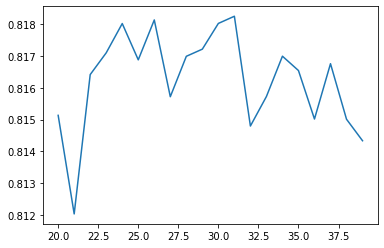

In [38]:
i = np.arange(20, 40, 1)
plt.plot(i, scores_on_split)

## Catboost

In [ ]:
model =  CatBoostClassifier(depth=12,verbose=False)
model.fit(train,y)
model.score(train,y)

In [ ]:
y_pred = model.predict(test)
y_pred

## Pycaret

In [ ]:
train['Transported']

In [ ]:
from pycaret.classification import *
#num_cols = list(train.select_dtypes('float64').columns) + list(train.select_dtypes('int64').columns)

s = setup(data = train,
          target = 'Transported',
          train_size = 0.99,
          fold_strategy = 'stratifiedkfold',
          fold = 5,
          fold_shuffle = True,
          #numeric_features = num_cols,
          ignore_low_variance=True,
          remove_multicollinearity = True,
          imputation_type='iterative',
          #normalize = True,
          normalize_method = 'robust',
          data_split_stratify = True,
          #ignore_features = ['PassengerNo', 'Name', 'PassengerId', 'PassengerGroup', 'Cabin'],
          silent = True)

In [ ]:
# best_model = compare_models()

In [ ]:
# tuned_catboost = tune_model(catboost_m, optimize = 'Accuracy')

In [ ]:
# plot_model(catboost_m, plot = 'parameter')

In [ ]:
# plot_model(tuned_catboost, plot = 'parameter')

# Submission

In [ ]:
sub.head(2)

In [ ]:
# # y_pred = predict_model(lr, data=test)
# # y_pred = y_pred['Label']


# preds = []
# for i in y_pred:
#     if i == 0:
#         preds.append(False)
#     else:
#         preds.append(True)

# sub['Transported'] = preds

# sub.to_csv("/home/mikhail/Downloads/sample_submission.csv'", index=False)
# sub.head()

In [62]:
y_prob_3 = sum(y_probs_2) / len(y_probs_2)
y_prob_3

preds = []
for i in y_prob_3:
    if i[0] > i[1]:
        preds.append(False)
    else:
        preds.append(True)
        
def save_submission(y_pred):  
    #classes = label.inverse_transform(y_pred)
    sub["Transported"] = y_pred
    #assert len(classes) == sub.shape[0]
    assert 2 == sub.shape[1]   
    sub.to_csv("E:/downloads/sample_submission.csv", index=False)
    return sub
save_submission(preds).head(3)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
